In [5]:
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
from matplotlib import pyplot as plt

Component 1 points: [(np.int64(783), np.int64(253)), (np.int64(770), np.int64(217)), (np.int64(777), np.int64(228))]
Component 2 points: [(np.int64(665), np.int64(243)), (np.int64(671), np.int64(245)), (np.int64(592), np.int64(275))]


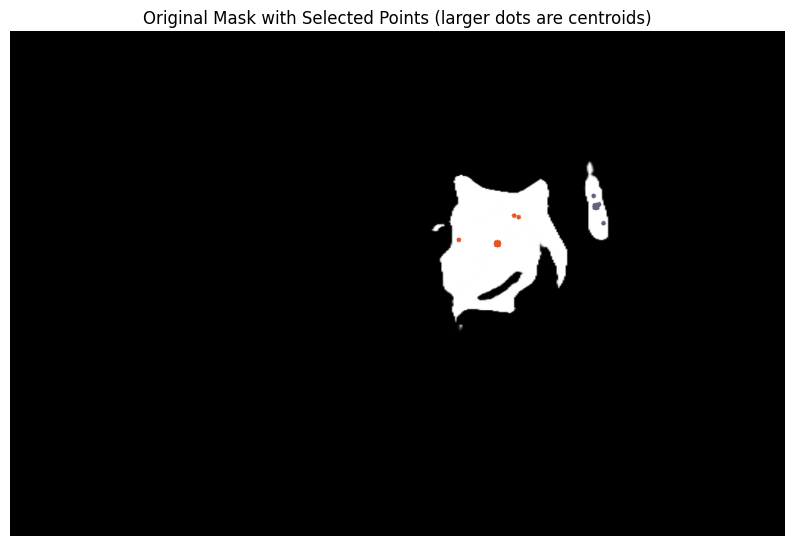

In [2]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt 
mask_path = '/school/CSCI_2470/final/HGINet/result/COD10K/COD10K-CAM-2-Terrestrial-23-Cat-1500.png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
filtered_mask = np.zeros_like(binary)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
image_pixel_num = mask.shape[0] * mask.shape[1]
min_pixel_threshold = 0.001 * image_pixel_num
decay_rate = 0.05  
component_points = []

for label in range(1, num_labels):
    pixel_count = np.sum(labels == label)
    if pixel_count >= min_pixel_threshold:
        filtered_mask[labels == label] = 255
        
        # Get coordinates of all points in this component
        y_coords, x_coords = np.where(labels == label)
        
        # Get centroid for this component
        centroid_x, centroid_y = centroids[label]
        
        # Calculate distances to centroid for all points
        distances = np.sqrt((x_coords - centroid_x)**2 + (y_coords - centroid_y)**2)
        
        # Convert distances to probabilities (closer points have higher probability)
        # Using exponential decay: exp(-distance)
        probabilities = np.exp(-distances * decay_rate)
        probabilities = probabilities / probabilities.sum()  # normalize
        
        # Select 3 points based on these probabilities
        selected_indices = np.random.choice(len(x_coords), size=3, p=probabilities, replace=False)
        points = [(x_coords[i], y_coords[i]) for i in selected_indices]
        component_points.append([label, points])
        print(f"Component {label} points: {points}")

# Visualize the points
vis_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# Draw points and centroids for each component
for label, points in component_points:
    # Generate a random color for this component
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    # Draw centroid
    centroid_x, centroid_y = centroids[label]
    cv2.circle(vis_mask, (int(centroid_x), int(centroid_y)), radius=5, color=color, thickness=-1)
    
    # Draw selected points
    for point in points:
        x, y = point
        cv2.circle(vis_mask, (x, y), radius=3, color=color, thickness=-1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(vis_mask, cv2.COLOR_BGR2RGB))
plt.title('Original Mask with Selected Points (larger dots are centroids)')
plt.axis('off')
plt.show()

Selected points from filtered mask: [(np.int64(604), np.int64(291)), (np.int64(664), np.int64(363)), (np.int64(606), np.int64(334))]


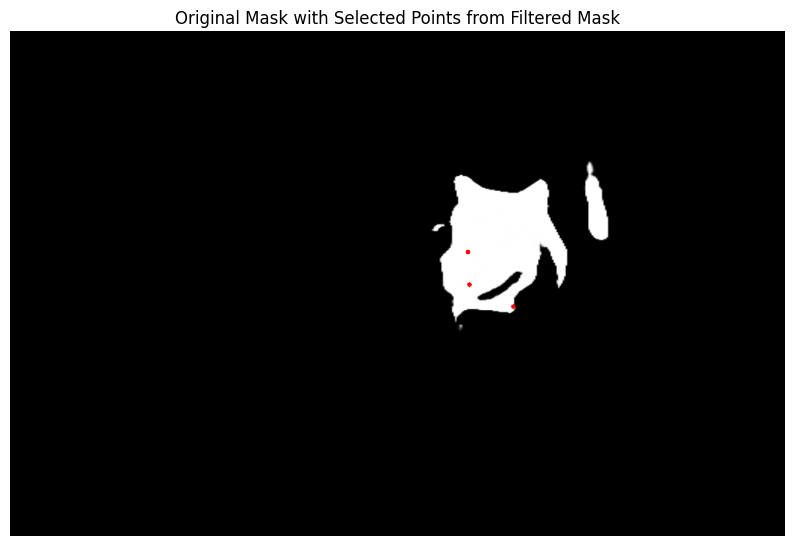

In [33]:
# Get coordinates of all points in the filtered mask
y_coords_filtered, x_coords_filtered = np.where(filtered_mask == 255)

# Randomly select 3 points from the filtered mask region
if len(y_coords_filtered) >= 3:
    indices = random.sample(range(len(y_coords_filtered)), 3)
    filtered_mask_points = [(x_coords_filtered[i], y_coords_filtered[i]) for i in indices]
    
    # Visualize these points on the mask
    vis_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # Draw the points in a distinct color (e.g., red)
    for point in filtered_mask_points:
        x, y = point
        cv2.circle(vis_mask, (x, y), radius=3, color=(0, 0, 255), thickness=-1)
    
    print("Selected points from filtered mask:", filtered_mask_points)
    
    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(vis_mask, cv2.COLOR_BGR2RGB))
    plt.title('Original Mask with Selected Points from Filtered Mask')
    plt.axis('off')
    plt.show()
else:
    print("Not enough points in the filtered mask to select 3 points")

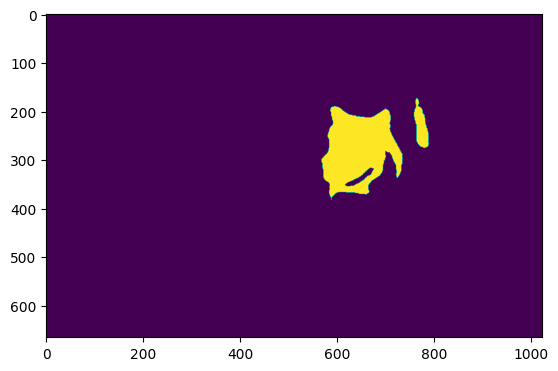

In [27]:
plt.imshow(filtered_mask)
# Create a kernel for dilation
kernel = np.ones((10,10), np.uint8)  # 3x3 kernel, you can adjust the size

# Perform dilation
dilated_mask = cv2.dilate(filtered_mask, kernel, iterations=1)  # you can adjust iterations

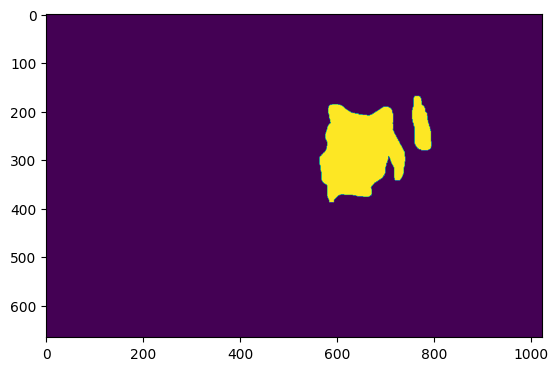

In [29]:
plt.imshow(dilated_mask)
dilated_region = dilated_mask - filtered_mask

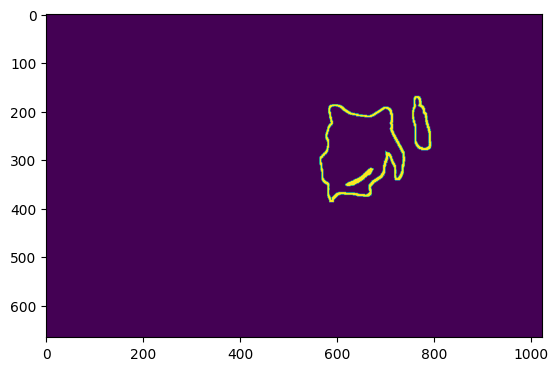

In [30]:
plt.imshow(dilated_region)

In [31]:
num_labels_dilated, labels_dilated, stats_dilated, centroids_dilated = cv2.connectedComponentsWithStats(dilated_region)

# For each component, select three points
selected_points = []  # will store [component_label, [points]]

for label in range(1, num_labels_dilated):  # skip background (label 0)
    # Get coordinates of all points in this component
    y_coords, x_coords = np.where(labels_dilated == label)
    
    # Only proceed if component has at least 3 points
    if len(y_coords) >= 3:
        # Randomly select 3 points
        indices = random.sample(range(len(y_coords)), 3)
        points = [(x_coords[i], y_coords[i]) for i in indices]
        selected_points.append([label, points])
        print(f"Component {label} points: {points}")

Component 1 points: [(np.int64(784), np.int64(278)), (np.int64(766), np.int64(273)), (np.int64(782), np.int64(222))]
Component 2 points: [(np.int64(739), np.int64(311)), (np.int64(711), np.int64(243)), (np.int64(575), np.int64(286))]
Component 3 points: [(np.int64(644), np.int64(341)), (np.int64(661), np.int64(323)), (np.int64(640), np.int64(341))]


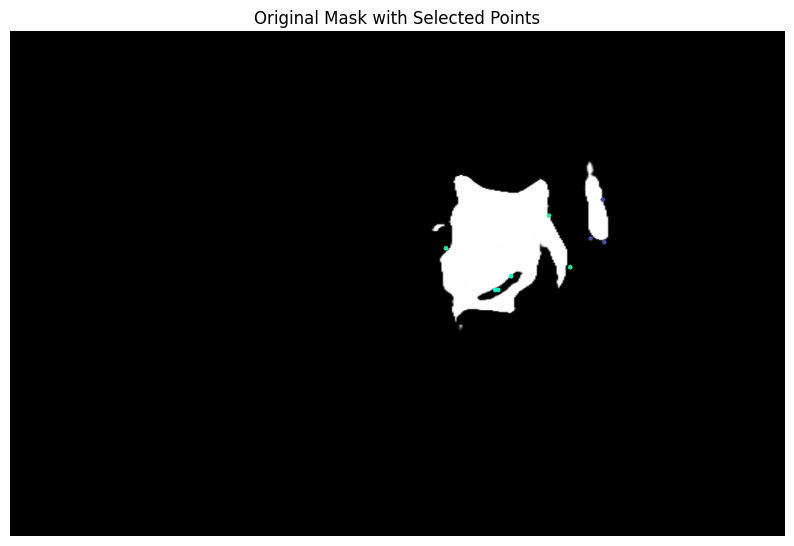

In [32]:
vis_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# Draw the points with different colors for each component
for label, points in selected_points:
    # Generate a random color for this component
    color = (
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)
    )
    
    # Draw each point as a filled circle
    for point in points:
        x, y = point
        cv2.circle(vis_mask, (x, y), radius=3, color=color, thickness=-1)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(vis_mask, cv2.COLOR_BGR2RGB))
plt.title('Original Mask with Selected Points')
plt.axis('off')
plt.show()

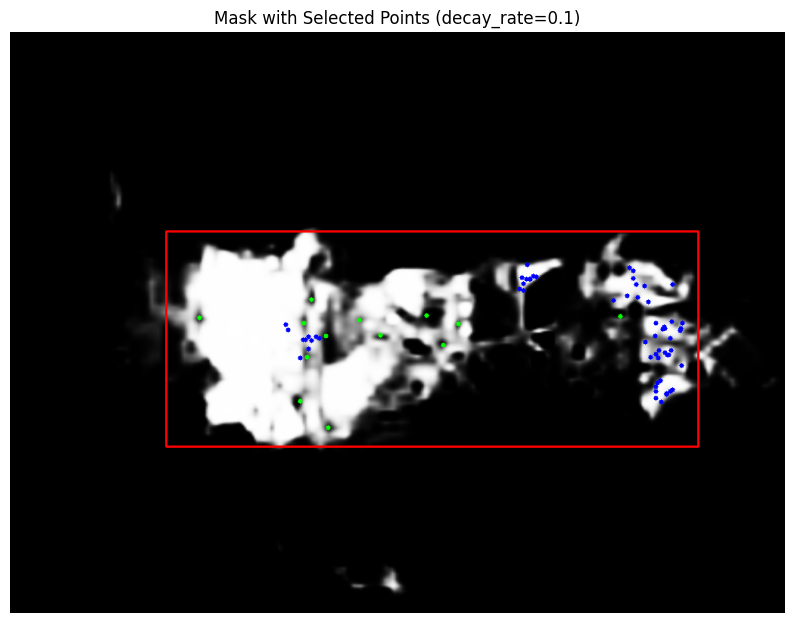

In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt 

def select_weighted_points(x_coords, y_coords, centroid, decay_rate=0.1, num_points=3):
    """Helper function to select points based on distance from centroid"""
    centroid_x, centroid_y = centroid
    distances = np.sqrt((x_coords - centroid_x)**2 + (y_coords - centroid_y)**2)
    probabilities = np.exp(-decay_rate * distances)
    probabilities =  probabilities / probabilities.sum()
    selected_indices = np.random.choice(len(x_coords), size=num_points, p=probabilities, replace=False)
    return [(x_coords[i], y_coords[i]) for i in selected_indices]

def process_mask(mask_path, min_component_thresh = 0.001, decay_rate=10, num_pos_samples=10, num_neg_samples=1, dilate_size = 40):
    # Read mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # First pass of connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
    image_pixel_num = mask.shape[0] * mask.shape[1]
    min_pixel_threshold = min_component_thresh * image_pixel_num
    
    # Process large enough components
    new_mask = np.zeros_like(binary)
    pos_samples = []
    for label in range(1, num_labels):
        pixel_count = np.sum(labels == label)
        if pixel_count >= min_pixel_threshold:
            # Add region to new mask
            new_mask[labels == label] = 255
            
            # Get coordinates and select points
            y_coords, x_coords = np.where(labels == label)
            points = select_weighted_points(x_coords, y_coords, centroids[label], decay_rate, num_pos_samples)
            pos_samples.append([label, points])
            
    # Get bounding box for new_mask
    y_coords, x_coords = np.where(new_mask == 255)
    if len(y_coords) > 0 and len(x_coords) > 0:
        x_min, x_max = np.min(x_coords), np.max(x_coords)
        y_min, y_max = np.min(y_coords), np.max(y_coords)
        bbox = [x_min, y_min, x_max, y_max]  # [left, top, right, bottom]
    else:
        bbox = None
    # Dilate the new mask
    kernel = np.ones((dilate_size,dilate_size), np.uint8)
    dilated_mask = cv2.dilate(new_mask, kernel, iterations=1)
    
    # Find new regions from dilation
    dilated_region = dilated_mask - new_mask
    
    # Second pass of connected components on dilated region
    num_labels_dilated, labels_dilated, stats_dilated, centroids_dilated = cv2.connectedComponentsWithStats(dilated_region)
    
    # Process new components
    neg_samples = []
    
    for label in range(1, num_labels_dilated):
        y_coords, x_coords = np.where(labels_dilated == label)
        if len(y_coords) >= 3:  # ensure enough points to select from
            points = select_weighted_points(x_coords, y_coords, centroids_dilated[label], 1, num_neg_samples)
            neg_samples.append([label, points])
    
    # Visualize results
    vis_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # Draw first pass points
    for label, points in pos_samples:
        color = (255, 0, 0)
        # Draw points
        for point in points:
            x, y = point
            cv2.circle(vis_mask, (x, y), radius=3, color=color, thickness=-1)
    
    # Draw second pass points
    for label, points in neg_samples:
        color = (0, 255, 0)
        # Draw points
        for point in points:
            x, y = point
            cv2.circle(vis_mask, (x, y), radius=3, color=color, thickness=-1)
    
    if bbox is not None:
        cv2.rectangle(vis_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(vis_mask, cv2.COLOR_BGR2RGB))
    plt.title(f'Mask with Selected Points (decay_rate={decay_rate})')
    plt.axis('off')
    plt.show()
    
    return new_mask, dilated_mask, pos_samples, neg_samples, bbox

# Use the function
mask_path = 'results/predictions/COD10K-CAM-2-Terrestrial-23-Cat-1378.png'
new_mask, dilated_mask, pos_samples, neg_samples, bbox = process_mask(mask_path, decay_rate=0.1)

In [2]:
import numpy as np
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  
    
def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [3]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "models/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

/school/CSCI_2470/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:773.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/school/CSCI_2470/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/school/CSCI_2470/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:775.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/school/CSCI_2470/sam2/sam2/modeling/sam/

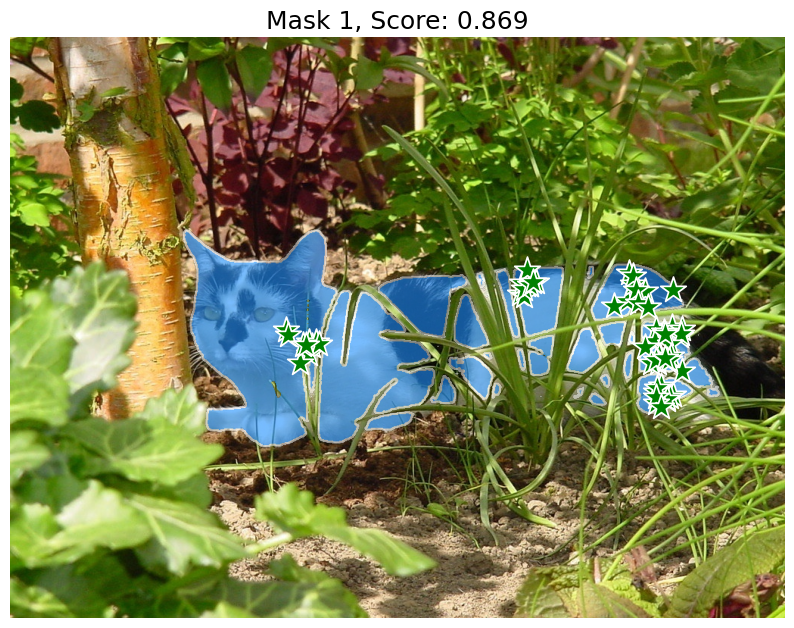

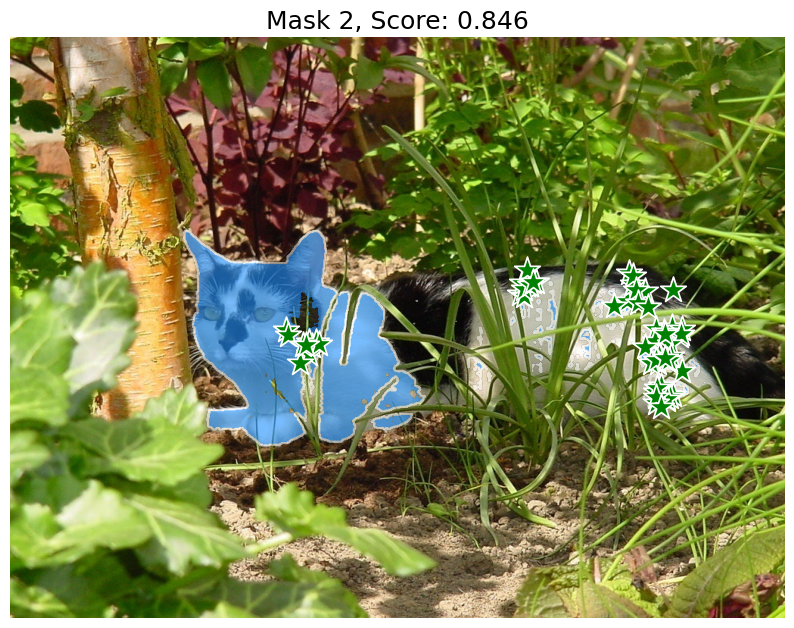

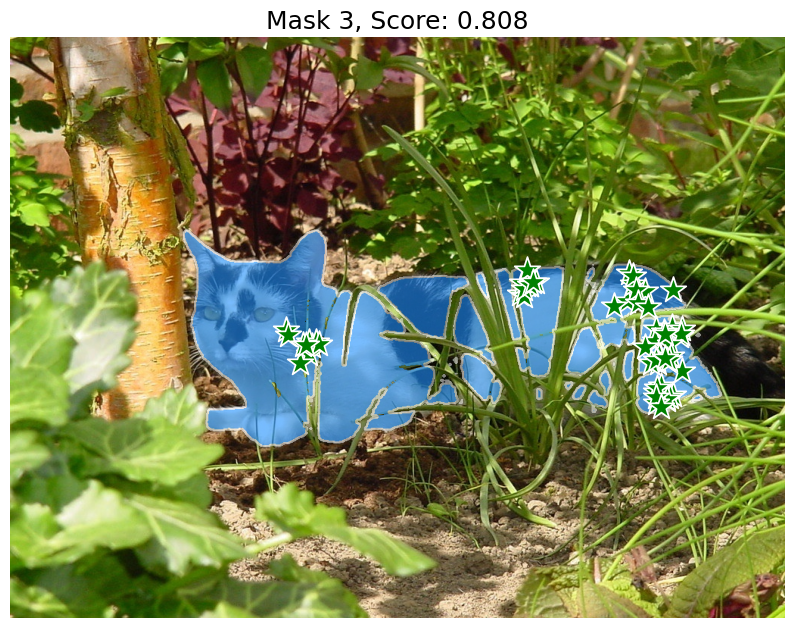

In [4]:
import cv2
image_path = '/school/CSCI_2470/final/HGINet/assets/TestDataset/COD10K/Imgs/COD10K-CAM-2-Terrestrial-23-Cat-1378.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

# Convert your samples to the format SAM expects
input_points = []
input_labels = []

# Process positive samples
for label, points in pos_samples:
    for point in points:
        input_points.append(point)
        input_labels.append(1)  # 1 for positive samples

# # Process negative samples
# for label, points in neg_samples:
#     for point in points:
#         input_points.append(point)
#         input_labels.append(0)  # 0 for negative samples

# Convert to numpy arrays
input_box = bbox
input_points = np.array(input_points)
input_labels = np.array(input_labels)

# Get masks from the model
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box = input_box,
    multimask_output=True  # Set to True if you want multiple mask predictions
)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]
show_masks(image, masks, scores, point_coords=input_points, input_labels=input_labels, borders=True)